<a href="https://colab.research.google.com/github/MostafaRizk/FireClassifier/blob/main/Fire_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code: #

First, you need to download the dataset. You can follow [these instructions](https://www.kaggle.com/general/74235) for creating a kaggle API token and using it.

In [2]:
# Sets up the kaggle API so you can import the dataset
# Upload the kaggle.json file you downloaded when creating a new API token

!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mkrizk","key":"828b00ba4a09189a06db18d7a2d40d82"}'}

In [3]:
# Create a directory for your kaggle data, give yourself read and write permissions and download the dataset

! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d phylake1337/fire-dataset

 96% 371M/387M [00:02<00:00, 159MB/s]
100% 387M/387M [00:02<00:00, 147MB/s]


In [ ]:
# Unzip the data, check the number of fire and non-fire images and create a separate directory for the learning process

! unzip fire-dataset.zip
! ls fire_dataset/fire_images/fire*.png | wc -l
! ls fire_dataset/non_fire_images/non_fire*.png | wc -l
! mkdir fire_learning

In [5]:
# Create directories for training, validation and testing and sub-directories for fire and non-fire images in each
import os, shutil

original_dir = "fire_dataset"
base_dir = "fire_learning"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

train_fire_dir = os.path.join(train_dir, "fire")
train_non_fire_dir = os.path.join(train_dir, "non_fire")
val_fire_dir = os.path.join(val_dir, "fire")
val_non_fire_dir = os.path.join(val_dir, "non_fire")
test_fire_dir = os.path.join(test_dir, "fire")
test_non_fire_dir = os.path.join(test_dir, "non_fire")

os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)
os.mkdir(train_fire_dir)
os.mkdir(train_non_fire_dir)
os.mkdir(val_fire_dir)
os.mkdir(val_non_fire_dir)
os.mkdir(test_fire_dir)
os.mkdir(test_non_fire_dir)

The dataset is skewed (there are more fire images than non-fire images). So in this next code segment I manually split the data to make sure that fire and non-fire images are equally represented in the validation data and the test data. The code here could be a bit neater (removing magic numbers, maybe using sklearn to split etc) but for now it gets the job done.

In [6]:
# Move files from the original directory to the new directory tree

original_fire_dir = os.path.join(original_dir, 'fire_images')
original_non_fire_dir = os.path.join(original_dir, 'non_fire_images')

# Fire
fnames = [f'fire.{i}.png' for i in range(1,656)]
for fname in fnames:
  src = os.path.join(original_fire_dir,fname)
  dest = os.path.join(train_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'fire.{i}.png' for i in range(656, 706)]
for fname in fnames:
  src = os.path.join(original_fire_dir,fname)
  dest = os.path.join(val_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'fire.{i}.png' for i in range(706, 756)]
for fname in fnames:
  src = os.path.join(original_fire_dir,fname)
  dest = os.path.join(test_fire_dir, fname)
  shutil.copyfile(src,dest)

# Non-fire
fnames = [f'non_fire.{i}.png' for i in range(1, 145)]
for fname in fnames:
  src = os.path.join(original_non_fire_dir,fname)
  dest = os.path.join(train_non_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'non_fire.{i}.png' for i in range(145, 195)]
for fname in fnames:
  src = os.path.join(original_non_fire_dir,fname)
  dest = os.path.join(val_non_fire_dir, fname)
  shutil.copyfile(src,dest)

fnames = [f'non_fire.{i}.png' for i in range(195, 245)]
for fname in fnames:
  src = os.path.join(original_non_fire_dir,fname)
  dest = os.path.join(test_non_fire_dir, fname)
  shutil.copyfile(src,dest)

In [7]:
# Check image counts to make sure the data split the way we intended
! ls fire_learning/train/fire/*.png | wc -l
! ls fire_learning/val/fire/*.png | wc -l
! ls fire_learning/test/fire/*.png | wc -l
! ls fire_learning/train/non_fire/*.png | wc -l
! ls fire_learning/val/non_fire/*.png | wc -l
! ls fire_learning/test/non_fire/*.png | wc -l

655
50
50
144
50
50


(1, 460, 860, 3)


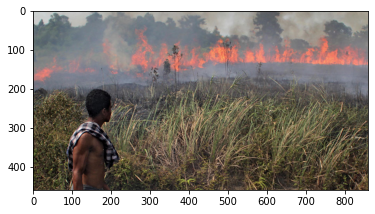

In [8]:
# Investigating to see what the fire images look like

from keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt

img_path = 'fire_learning/train/fire/fire.1.png'
img = image.load_img(img_path)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

# Adapting the Model to the Dataset: #

So far, everything is very similar to the example in the Chollet book but here is where I deviate substantially. Mainly, I dramatically reduce the network size and investigate some different metrics.

## Less is More ##

>The commented code was my first attempt, based on Chollet's model for differentiating between cats and dogs. Chollet actually had an additionl 2 blocks of convolutions and max pooling. I cut those out and reduced the number of filters in the convolutional layers as well as the number of neurons in the dense layer. My thinking is that pictures of fire are much simpler than pictures of cats and dogs. Faces, in general, have a lot of detail. It makes sense that you would need several convolutional blocks. The first block would learn to detect the different types of edges, a later block would learn to detect more general facial features like eyes and noses etc. 

>Fire, by comparison, is a *lot* simpler. Fire doesn't have complex features like eyes or ears that vary significantly from fire to fire. In fact, I would wager that if all you could do was detect the colour orange, your classifier would be mostly done. But of course, there are other features. We don't want to get cocky and underthink the problem. Sometimes smoke can change the hue of the fire. Houses or flowers in the landscape might be orange. A sunset might be orange. So there needs to be a little bit of sophistication.

>In general, though, I subscribe to the school of thought that neural networks should be as small as possible and I think people often fall into the trap of just adding more layers and more neurons when they get stuck. This is fine if you have the resources to quickly train huge models, but why use all that time and energy when you don't need to? 

> I tried the Chollet model and sure enough it was overfitting (based on the validation and loss plots farther down). So i did a few iterations where I decreased the number of layers, filters and neurons until the loss and validation curves aligned. 

## Other changes ##

>My radical minimalist agenda aside, I made some other changes to Chollet's approach. One of them was using recall as a metric rather than accuracy. My thinking here was that if this model was being deployed, it would probably be deployed to monitor for bushfires/wildfires in remote areas and inform authorities so they can respond quickly. In such a situation, it is *much* better to have a false alarm than to miss a fire that then goes on to spread and cause devastating loss of life. Recall is used to minimise false negatives, so I chose that as one of my metrics. I included precision and accuracy as well just to have a broader idea of how well the model is doing. I don't want to inadvertently create a model that always predicts fire. Boy who cried wolf and whatnot. 



In [9]:
# Create the model

from keras import models, layers, optimizers, metrics

'''First attempt
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))'''

model = models.Sequential()
model.add(layers.Conv2D(10, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[metrics.Recall(), metrics.Precision(), 'acc'])

I went through about 9 iterations before I settled on a model that worked. In the first 8 iterations, all of the models suffered from overfitting. Each time I removed convolutional blocks or reduced the number of filters or reduced the number of neurons in the second-to-last dense layer (before removing that layer entirely). I got down to 3 filters at one point and the loss, recall and accuracy plots still showed signs of overfitting. When I added dropout, that was when the results finally stabilised. 

I settled on this model, but I suspect that you could probably go even simpler. However, while it would work on *this* dataset, I think it would be bad for fire detection in general because the dataset is flawed, which I'll get into farther down.

In [10]:
# Create generators for data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150,150), 
                                                    class_mode='binary', 
                                                    batch_size=20,
                                                    seed=1)

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                target_size=(150,150), 
                                                class_mode='binary', 
                                                batch_size=20,
                                                seed=1)

Found 799 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [11]:
# Train
history = model.fit(train_generator,
                    steps_per_epoch=799//20,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=100//20)

model.save('fire_classifier_v9_dropout.h5')

Epoch 1/30
39/39 [==============================] - 42s 992ms/step - loss: 0.3749 - recall: 0.5634 - precision: 0.6612 - acc: 0.8678 - val_loss: 0.1389 - val_recall: 0.9800 - val_precision: 0.9245 - val_acc: 0.9500
Epoch 2/30
39/39 [==============================] - 34s 844ms/step - loss: 0.1779 - recall: 0.7817 - precision: 0.8346 - acc: 0.9320 - val_loss: 0.2736 - val_recall: 0.7800 - val_precision: 1.0000 - val_acc: 0.8900
Epoch 3/30
39/39 [==============================] - 33s 858ms/step - loss: 0.1104 - recall: 0.8345 - precision: 0.8923 - acc: 0.9525 - val_loss: 0.4630 - val_recall: 0.6400 - val_precision: 1.0000 - val_acc: 0.8200
Epoch 4/30
39/39 [==============================] - 33s 857ms/step - loss: 0.1126 - recall: 0.8417 - precision: 0.8864 - acc: 0.9525 - val_loss: 0.1662 - val_recall: 0.8800 - val_precision: 0.9778 - val_acc: 0.9300
Epoch 5/30
39/39 [==============================] - 33s 831ms/step - loss: 0.0830 - recall: 0.9085 - precision: 0.9281 - acc: 0.9705 - val_l

Note that for the plotting, sometimes the recall and val_recall values get stored in the history dictionary as recall_i and val_recall_i, where i is a number. This happens when I re-train the model. I'm sure there's some resource out there that explains why this happens and how to stop it, but I haven't found it yet. I think it has something to do with recreating the generator. In any case, you may need to change those 2 lines.

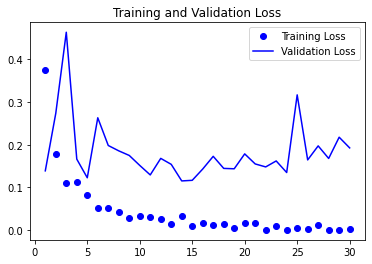

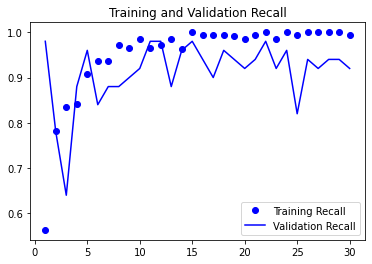

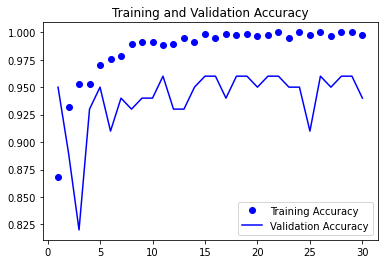

In [12]:
from matplotlib import pyplot as plt

recall = history.history['recall']
val_recall = history.history['val_recall']
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(recall)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label="Validation Recall")
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

The results are a little different every time. But if it worked for you like it did for me, the validation curve is very close to the training curve for all the plots. You could probably keep making the model better given that there's still a small gap between the two curves in each plot that suggests a small amount of overfitting, but I was happy with that and decided to cut myself off. Given that this is mostly an educational project, the goal was just to get a reasonably good solution, add it to the portfolio and move on to the next thing. So by all means, don't take this as the be-all/end-all solution.

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_recall, test_precision, test_acc = model.evaluate(test_generator, steps=50) 
print('test recall:', test_recall)
print('test precision:', test_precision)
print('test acc:', test_acc)

Found 100 images belonging to 2 classes.
50/50 [==============================] - 3s 47ms/step - loss: 0.1732 - recall: 0.9600 - precision: 0.9796 - acc: 0.9700
test recall: 0.9599999785423279
test precision: 0.9795918464660645
test acc: 0.9700000286102295


Our model was a success! 97% accuracy with a single convolutional block! I was honestly surprised by this outcome. I looked at some of the other solutions before testing my model and they used ***massive*** networks to achieve the same result. For example, [this one solution](https://www.kaggle.com/code/delllectron/fire-detection-computer-vision/notebook) used the Xception model (trained on imagenet) as a convolutional base, then used feature extraction to produce input for a new head consisting of 3 additional dense layers. The Xception base has 20 million parameters, while the new head is 500,000. In comparison, my model is 50,000 parameters. Take a look.

In [79]:
# My model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 10)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 54760)             0         
                                                                 
 dropout (Dropout)           (None, 54760)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 54761     
                                                                 
Total params: 55,041
Trainable params: 55,041
Non-trainable params: 0
__________________________________________________

In [23]:
# Xception model for comparison
from keras.applications import xception

xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
xception_bf.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

I felt like I was losing my mind! How?! Surely there must be some insight that I'm missing. Why are people using such massive networks when small ones are successful? Before testing I was half-expecting that my model would completely fail on the test data. But sure enough it didn't. 

The hunch that allowed me to make the model so small was the hunch that being able to detect a few simple visual features (particularly the colour orange) should be enough to detect fires. But I added some extra filters to allow for other features like the shape of flames and hue of smoke etc. With my model being so successful, I was curious if my hunch was right and it did indeed just learn to detect the colour orange. I put together a few pictures that I grabbed off of google image search to see with my own eyes how well the model works and whether or not I could trick it. The pictures are all available in the demo_pics folder.

In [ ]:
# Download some images of fires and upload them to the home directory
files.upload()

Having lived in Australia during the 2020 Black Summer bushfires, I explicitly searched for pictures of Australian fires to see if my model could be helpful for future bushfires. The first 3 pictures I chose are unmistakably of fire but I tried to pick a few that would test the model's possible weaknesses. For example, the third fire picture is mostly smoke with only a tiny flame, to see if the model detects smoke as well. The second picture has the silhouette of a kangaroo in it. I suspected the dataset did not include Aussie samples so this shape would be unfamiliar to the model. Now, the presence of this shape is unlikely to influence the decision made, but I thought it would be fun to chuck it in and see what happens. There is precedent for [kangaroos confusing vision models](https://www.abc.net.au/news/2017-06-24/driverless-cars-in-australia-face-challenge-of-roo-problem/8574816) deployed in Australia.

The second row of pictures are non-burning Aussie landscapes. The third is sunsets to see if the orange hue would trick the model (and me low-key flexing how scenic Australia is).

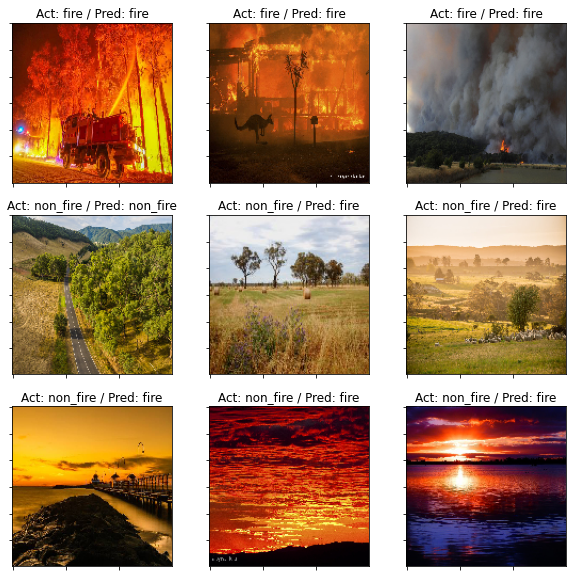

In [15]:
# Create a list of image paths
fire_paths = ['demo_fire_1.jpg', 'demo_fire_2.png', 'demo_fire_3.jpg']
non_fire_paths = [f'demo_non_fire_{i}.jpg' for i in [1,2,3]]
sunset_paths = [f'sunset_{i}.jpg' for i in [1,2,3]]
img_paths = fire_paths + non_fire_paths + sunset_paths

true_labels = ['fire']*3 + ['non_fire']*6
label_map = train_generator.class_indices
inv_map = {value: key for key, value in label_map.items()}

imgs = [image.load_img(img_path, target_size=(150, 150)) for img_path in img_paths]
img_tensor = np.array([image.img_to_array(img) for img in imgs])
#img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

y_pred = model.predict(img_tensor) 
y_classes = np.where(y_pred > 0.5, 1,0)

#print(inv_map[y_classes[0]])
#print(label_map)

fig = plt.figure(figsize=(10,10))

for i in range(len(img_tensor)):
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img_tensor[i])
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_title(f'Act: {true_labels[i]} / Pred: {inv_map[y_classes[i][0]]}')

plt.show()

So, the model works prefectly for all the fire pictures, and as expected it is tricked by all the sunset pictures into thinking they are fires. So we can pretty safely assume that the convolutional block picks up on the colour orange as an indicator of fire and that the dataset doesn't include pictures taken at sunset.

What's interesting is that for the non-fire landscape pictures, the model thinks 2 of them contain fires. I'm not entirely sure why this is. For the second picture in that row, my hunch is that it's mis-classified because the grass is yellow-ish. If a fire has occurred somewhere, it's often preceded by drought so it could be that a lot of the fire pictures are in places where the grass is yellow-ish. For the third picture, I deliberately picked that one because the air is a little hazy to see if that was enough to trick the model, and it was.

The first picture was classified correctly, though. One thing I noticed is that it has a big chunk of very green trees. This got me wondering if the model would work on landscapes that are a bit lusher. I grabbed a few pictures of landscapes that are green. 

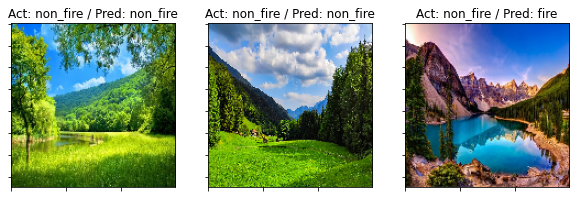

In [16]:
img_paths = ['green_1.jpg', 'green_2.jpg', 'green_3.jpg']

true_labels = ['non_fire']*3

imgs = [image.load_img(img_path, target_size=(150, 150)) for img_path in img_paths]
img_tensor = np.array([image.img_to_array(img) for img in imgs])
img_tensor /= 255.

y_pred = model.predict(img_tensor) 
y_classes = np.where(y_pred > 0.5, 1,0)

fig = plt.figure(figsize=(10,10))

for i in range(len(img_tensor)):
  ax = fig.add_subplot(1, 3, i+1)
  ax.imshow(img_tensor[i])
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_title(f'Act: {true_labels[i]} / Pred: {inv_map[y_classes[i][0]]}')

plt.show()

Lo and behold, the model works (I've had mixed results on the last picture with the lake when I've re-run this notebook)! Now I'm not entirely sure where all these pictures are from but I got some of them by looking up Canadian landscapes. Now, I can't say this with certainty but based on this quick and informal testing, I suspect the dataset consists mostly of North American landscapes. According to the dataset's page, it was produced as part of the NASA Space Apps Challenge by [gathering images from Google](https://2018.spaceappschallenge.org/challenges/volcanoes-icebergs-and-asteroids-oh-my/real-time-fire-app/teams/the-faze/stream/). It's difficult to say where all the pictures were from. The team that produced that dataset uses the American term 'wildfire' rather than Australian 'bushfire' to refer to fires, so if they used that as a search term, the fire pictures might be primarily from American outlets. Though they could be from American articles about Australian fires. And in any case, the detection of fires in Australian pictures doesn't seem to be a problem, it's the detection of non-fires. 

The point is that the dataset is probably not equally representative of the geography of different countries. It also probably does not include many pictures taken at sunset or sunrise because orange hues are enough to trick the model. In fact...

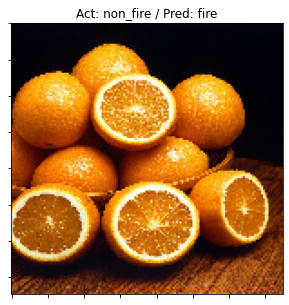

In [21]:
img_path = 'oranges.jpg'
true_label = 'non_fire'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

y_pred = model.predict(img_tensor) 
y_class = 1 if y_pred > 0.5 else 0 

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_tensor[0])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(f'Act: {true_label} / Pred: {inv_map[y_class]}')
plt.show()

You heard it here first, folks. Oranges are on fire. Assuming your model got the same results as mine. So the model is basically a colour detector. I think this is because the dataset is flawed. But I'm curious if a more sophisticated model would avoid these pitfalls. So I'm going to grab the XCeption model from earlier and see how it does. To be fair, the base of the model is fixed and the trained head is only 500k parameters. So there are only 10 times more parameters being trained than my model. The overall model is bigger, which will consume more computation and energy on the forward pass but that's negligible compared to training. So it could be worthwhile! 

But on the other hand, imagenet [doesn't contain](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) any classes for fire. It does contain classes for firetrucks, though. Does the dataset contain pictures of firemen extinguishing fires? Maybe. If so, that's not very helpful for detecting the early warning signs of fire and could lead to false positives where any picture containing a fire truck is classified as on fire. This would, ironically, include firestations. Imagenet also has pictures of animals. Maybe the presense of lots of animals could act as a proxy for a safe area? I don't know. But let's give it a whirl.

In [27]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 2048)) # 2048 is the output shape of the Xception base
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory, 
                                          target_size=(150, 150), 
                                          batch_size=batch_size, 
                                          class_mode='binary')
  
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = xception_bf.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch 
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  
  return features, labels

train_features, train_labels = extract_features(train_dir, 799) 
validation_features, validation_labels = extract_features(val_dir, 100) 
test_features, test_labels = extract_features(test_dir, 100)

Found 799 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


The code above (from the Chollet book) extracts features from the xception model when it's applied to the dataset. These features are then used as input to the new model head.

In [28]:
new_model = models.Sequential()
new_model.add(layers.Dense(units = 256 , activation = 'relu', input_dim=2048))
new_model.add(layers.Dense(units = 64 , activation = 'relu'))
new_model.add(layers.Dense(units = 1, activation = 'sigmoid'))
new_model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics=[metrics.Recall(), metrics.Precision(), 'acc'])
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = new_model.fit(train_features,
                        train_labels,
                        epochs=100,
                        batch_size=32,
                        validation_data=(validation_features, validation_labels))

new_model.save('fancy_model.h5')

Epoch 1/100
25/25 [==============================] - 2s 34ms/step - loss: 0.2179 - recall_2: 0.6875 - precision_2: 0.7674 - acc: 0.9061 - val_loss: 0.0862 - val_recall_2: 0.9800 - val_precision_2: 0.9800 - val_acc: 0.9800
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0903 - recall_2: 0.9375 - precision_2: 0.9375 - acc: 0.9775 - val_loss: 0.1554 - val_recall_2: 0.9200 - val_precision_2: 1.0000 - val_acc: 0.9600
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0489 - recall_2: 0.9653 - precision_2: 0.9521 - acc: 0.9850 - val_loss: 0.0779 - val_recall_2: 0.9600 - val_precision_2: 1.0000 - val_acc: 0.9800
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0294 - recall_2: 0.9792 - precision_2: 0.9724 - acc: 0.9912 - val_loss: 0.1749 - val_recall_2: 0.9200 - val_precision_2: 1.0000 - val_acc: 0.9600
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0135 - recall_2: 0.9861 - precision_2: 1

Now we plot the learning curves.

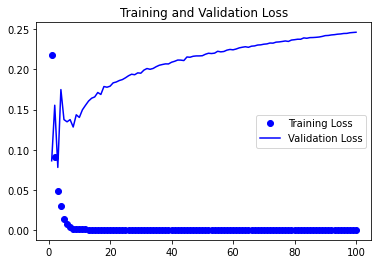

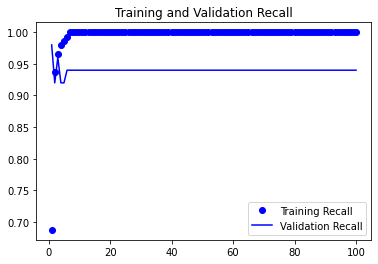

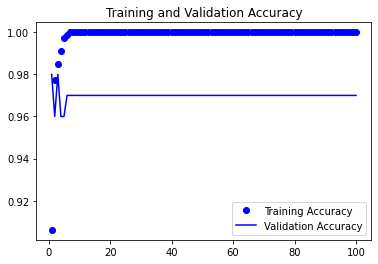

In [30]:
recall = history.history['recall_2']
val_recall = history.history['val_recall_2']
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(recall)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b-', label="Validation Recall")
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [32]:
test_loss, test_recall, test_precision, test_acc = new_model.evaluate(test_features, test_labels, steps=50)
print('test recall:', test_recall)
print('test precision:', test_precision)
print('test acc:', test_acc)

50/50 [==============================] - 0s 2ms/step - loss: 0.2725 - recall_2: 0.9400 - precision_2: 1.0000 - acc: 0.9700
test recall: 0.9399999976158142
test precision: 1.0
test acc: 0.9700000286102295


So it looks like the accuracy is basically the same. All that extra work and no extra payoff? Let's take a look at the images I collected just to be sure.

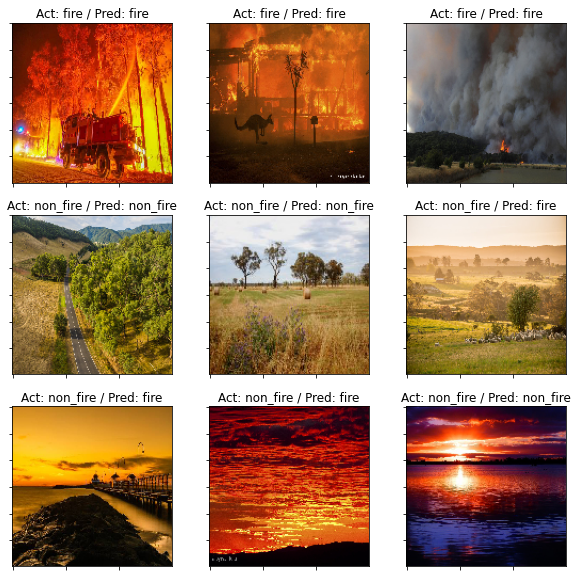

In [36]:
img_paths = fire_paths + non_fire_paths + sunset_paths
true_labels = ['fire']*3 + ['non_fire']*6

imgs = [image.load_img(img_path, target_size=(150, 150)) for img_path in img_paths]
img_tensor = np.array([image.img_to_array(img) for img in imgs])
img_tensor /= 255.

intermediate_output = xception_bf.predict(img_tensor)
y_pred = new_model.predict(intermediate_output) 
y_classes = np.where(y_pred > 0.5, 1,0)

fig = plt.figure(figsize=(10,10))

for i in range(len(img_tensor)):
  ax = fig.add_subplot(3, 3, i+1)
  ax.imshow(img_tensor[i])
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_title(f'Act: {true_labels[i]} / Pred: {inv_map[y_classes[i][0]]}')

plt.show()

So this is already interesting. The bigger model correctly classifies the second non-fire landscape but still fails on the third. And it still misclassifies the first two sunsets but gets the third one right. So it appears the imagenet pre-training makes the model a *little* bit better. But it's still heavily reliant on colour as a predictor of class. I suspect that some tiny tweaks to my smaller model could help us bridge the gap. But it's not a very big gap to bridge. Let's check out the green landscapes.

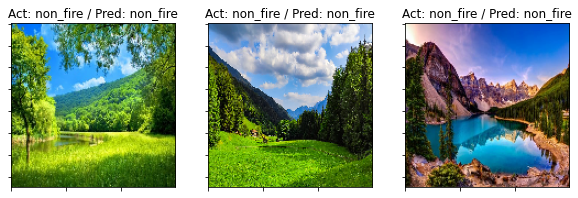

In [37]:
img_paths = ['green_1.jpg', 'green_2.jpg', 'green_3.jpg']
true_labels = ['non_fire']*3

imgs = [image.load_img(img_path, target_size=(150, 150)) for img_path in img_paths]
img_tensor = np.array([image.img_to_array(img) for img in imgs])
img_tensor /= 255.

intermediate_output = xception_bf.predict(img_tensor)
y_pred = new_model.predict(intermediate_output) 
y_classes = np.where(y_pred > 0.5, 1,0)

fig = plt.figure(figsize=(10,10))

for i in range(len(img_tensor)):
  ax = fig.add_subplot(1, 3, i+1)
  ax.imshow(img_tensor[i])
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_title(f'Act: {true_labels[i]} / Pred: {inv_map[y_classes[i][0]]}')

plt.show()

All three were correctly classified whereas my model is sometimes wrong about the third picture.

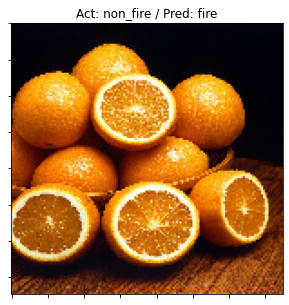

In [38]:
img_path = 'oranges.jpg'
true_label = 'non_fire'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

intermediate_output = xception_bf.predict(img_tensor)
y_pred = new_model.predict(intermediate_output) 
y_class = 1 if y_pred > 0.5 else 0 

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_tensor[0])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title(f'Act: {true_label} / Pred: {inv_map[y_class]}')
plt.show()

Oranges are still on fire.

## Final Thoughts ##

So, overall, there are two main takeaways here. 

The first is that small models are often enough to get the job done and not everything needs to be solved by huge neural networks pre-trained on imagenet. My small model got the same test accuracy as the larger model and slightly higher recall (although lower precision). 

The second takeaway, though, is that your models are only as good as the dataset. I thought this dataset was produced as part of some NASA-affiliated research project but on closer inspection it was just images scraped off Google by a team competing in a NASA challenge. While the dataset made for an excellent study tool and proof of concept, it was perhaps not quite enough to produce a model that's ready for deployment, especially in diverse settings, regardless of how sophisticated that model is. If you tried to use either of the two models I trained in this notebook, they would raise false alarms at sunsrise and sunset and wouldn't work with some countries' vegetations. In a nutshell, you would need a more comprehensive dataset if you wanted to deploy this seriously.

All in all, a fun learning exercise that was useful for me and is hopefully of benefit to whoever stumbles across this notebook!